In [22]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (6, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


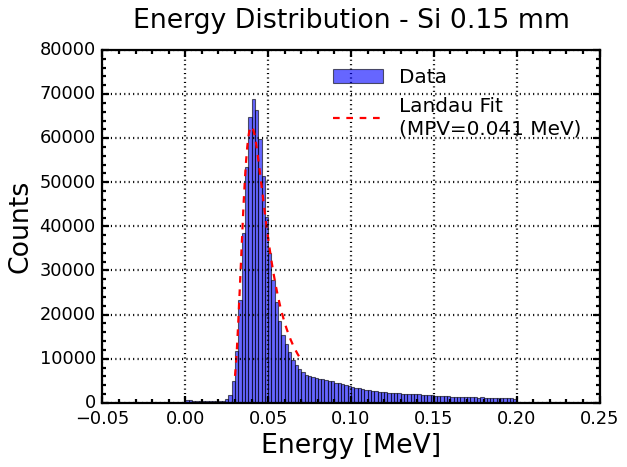

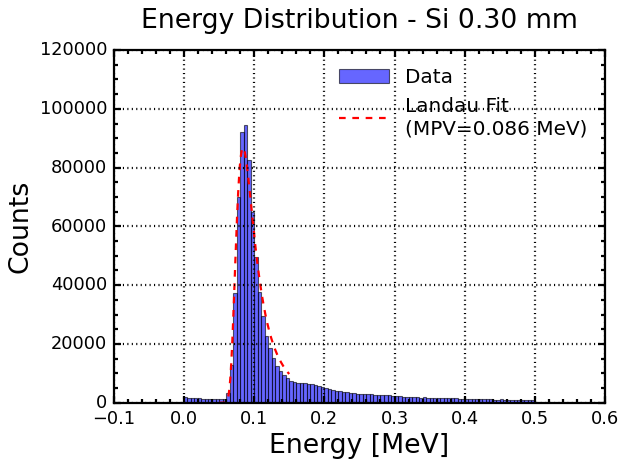

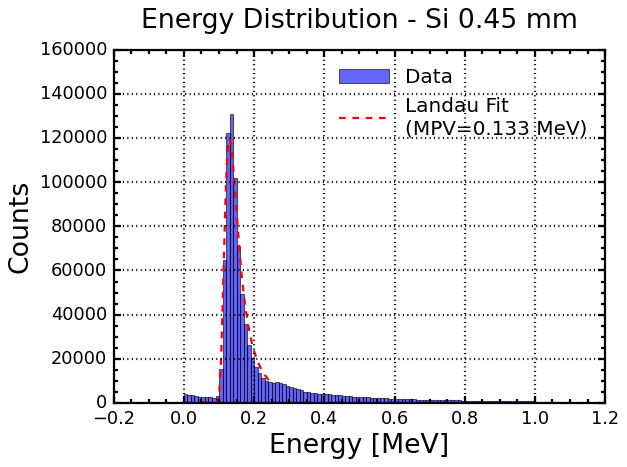

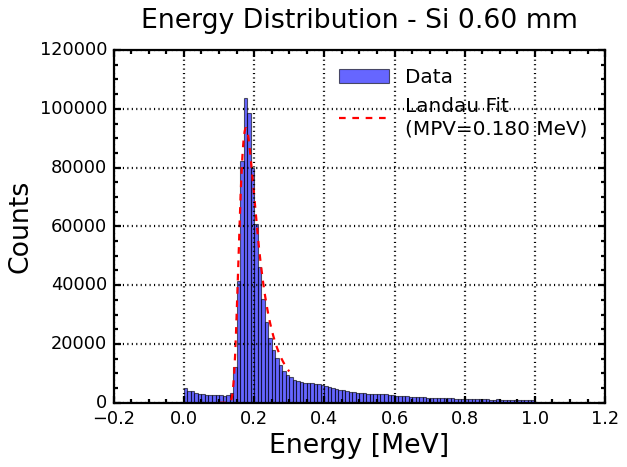

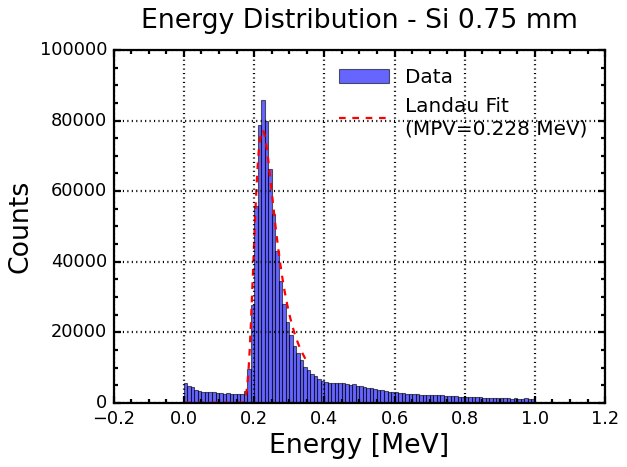

Si_Z (mm) | MPV (MeV)
    0.15 |   0.0410 ± 0.0000109010
    0.30 |   0.0861 ± 0.0000200069
    0.45 |   0.1328 ± 0.0000293615
    0.60 |   0.1803 ± 0.0000379224
    0.75 |   0.2282 ± 0.0000461222


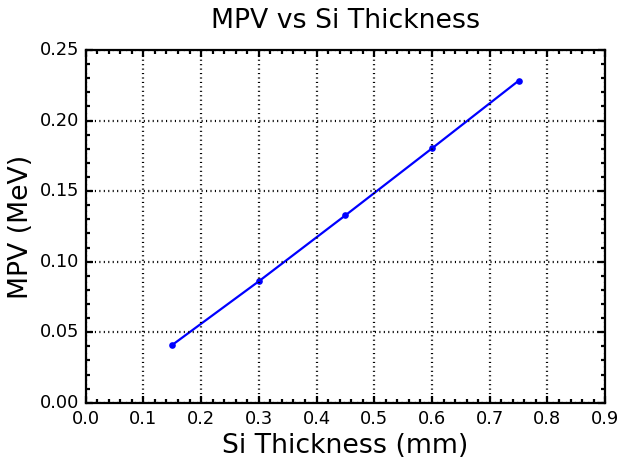

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


In [50]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
fig_size = (8, 6)
Si_Z_values = [0.15, 0.3, 0.45, 0.6, 0.75]
mpv_fit = []
mpv_fit_error = []
X_range = ((0,0.2,100), (0,0.5,100), (0,1,100), (0,1,100), (0,1,100))  # X轴范围
fitrange = ((0.03, 0.07), (0.05, 0.15), (0.05, 0.25), (0.1, 0.3), (0.0, 0.35))  # 拟合范围
for i in range(len(Si_Z_values)):
    Si_Z = Si_Z_values[i]
    # 生成路径（保留一位小数）
    DataPath = f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/mu-/Merged_X5.0mm_Y5.0mm_Si{Si_Z}mm_layer80_in80"
    file_path = f"{DataPath}/100.0GeV.root"

    # 打开 ROOT 文件
    file = uproot.open(file_path)
    tree = file["events"]

    # 读取数据
    energy = tree["simplecaloRO.energy"].array(library="np")

    # 直方图绘图
    all_energy = np.concatenate(energy) * 1000  # 转为 MeV
    counts, bins = np.histogram(all_energy, bins=X_range[i][2], range=(X_range[i][0], X_range[i][1]))
    hist = ROOT.TH1F("hist", "Energy", X_range[i][2], X_range[i][0], X_range[i][1])
    for i_bin in range(len(counts)):
        hist.SetBinContent(i_bin + 1, counts[i_bin])  # ROOT 的 bin 从 1 开始

    landau_func = ROOT.TF1("landau", "landau", fitrange[i][0], fitrange[i][1])
    hist.Fit("landau", "Q")  # "Q"：静默模式，不弹窗也不输出

    mpv = landau_func.GetParameter(1)  # 第2个参数是 MPV
    mpv_fit.append((Si_Z, mpv))
    mpv_fit_error.append(landau_func.GetParError(1))  # 获取 MPV 的误差

    x = np.linspace(fitrange[i][0], fitrange[i][1], 500)
    y = np.array([landau_func.Eval(v) for v in x])
    plt.figure(figsize=(8, 6))
    plt.hist(all_energy, bins=X_range[i][2], range=(X_range[i][0], X_range[i][1]), alpha=0.6, label="Data", color='blue')
    plt.plot(x, y, 'r--', label=f"Landau Fit \n(MPV={mpv:.3f} MeV)")
    plt.title(f"Energy Distribution - Si {Si_Z:.2f} mm")
    plt.xlabel("Energy [MeV]")
    plt.ylabel("Counts")
    plt.legend(loc='upper right', fontsize='18')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 打印 MPV 结果
print("Si_Z (mm) | MPV (MeV)")
for Si_Z, mpv in mpv_fit:
    print(f"{Si_Z:8.2f} | {mpv:8.4f} ± {mpv_fit_error[Si_Z_values.index(Si_Z)]:.10f}")
plt.figure(figsize=fig_size)
plt.errorbar([Si_Z for Si_Z, mpv in mpv_fit], [mpv for Si_Z, mpv in mpv_fit], yerr=mpv_fit_error, marker='o', linestyle='-', color='blue')
plt.title("MPV vs Si Thickness")
plt.xlabel("Si Thickness (mm)")
plt.ylabel("MPV (MeV)")
plt.grid(True)
plt.tight_layout()
plt.show()